# Projeto de Análise Preditiva de Inadimplência

### Simulação de ganhos em decisão de crédito com uso de modelo preditivo

Esta simulação tem como objetivo estimar o impacto financeiro da aplicação de um modelo de Machine Learning na decisão de aprovar ou negar crédito para clientes, comparando com o cenário onde o banco aprova todos indiscriminadamente. 

#### Cenário A: Com Modelo 

Neste cenário, usamos um modelo preditivo (Random Forest) treinado com os dados dos clientes. A decisão de aprovar ou negar crédito é baseada na previsão do modelo: 

- Se o modelo prevê que o cliente vai pagar (classe 0) → APROVA; 
- Se o modelo prevê que o cliente vai dar calote (classe 1) → NEGA. 

A qualidade do modelo foi avaliada por meio da matriz de confusão com os seguintes valores: 



 

Cálculo de Lucro com Modelo 
- Usamos valores médios reais do dataset para estimar o ganho/perda: 
- Lucro por cliente bom aprovado (VP): R$ 255,59 
- Prejuízo por cliente ruim aprovado (FP): R$ 2.562,01 
- Perda de oportunidade por cliente bom negado (FN): R$ 255,59 
- Negar cliente ruim (VN): sem ganho ou perda 


Resultados:  

- Lucro com modelo preditivo (XGBoost): R$ 15,810,677.12  
- Prejuízo sem modelo (aprovação irrestrita): R$ -18,034,991.56  
- Diferença de ganho ao usar o modelo: R$ 33,845,668.68 

#### Cenário B: Sem Modelo 

1. Regras Manuais

A estratégia baseada em regras manuais considerou os seguintes critérios para aprovação:

- Score externo (ext_score_1) acima de 550
- Renda superior a R$ 3.500
- Ocupação do tipo "CLT", "public" ou "servidor público"
- Comprometimento com dívidas ativas inferior a 50% da renda

2. Resultados:
Taxa de aprovação: aproximadamente 21% dos clientes

Inadimplência entre os aprovados: 63,65%

Lucro estimado total: R$ XX.XXX (calculado com +R$ 1.000 por cliente adimplente aprovado e -R$ 2.000 por inadimplente)

Insghts:  

O uso do modelo preditivo resultaria em um ganho estimado de mais de R$ 33 milhões em comparação com a aprovação irrestrita de crédito. 
A estratégia baseada em Machine Learning é altamente recomendável para maximizar lucros e mitigar riscos de inadimplência. 

Apesar de a estratégia manual ser mais conservadora, ela acabou rejeitando diversos clientes adimplentes, o que representa perda de receita potencial. O modelo XGBoost demonstrou maior capacidade de identificar padrões não-lineares, aprovando clientes com bom histórico que seriam barrados pelas regras manuais, resultando em maior lucro estimado total e menor taxa de inadimplência em grupos específicos.

Essa análise evidencia que a incorporação de modelos preditivos no processo de decisão pode otimizar a política de crédito, combinando maior retorno financeiro com controle de risco.

#### Modelo em produção:

In [1]:
import os
import random
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

# Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, cross_val_predict
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from scipy.stats import ks_2samp
from xgboost import plot_importance
from sklearn.metrics import log_loss

In [2]:
# Caminho relativo correto a partir da pasta 'notebooks'
df = pd.read_pickle('../data/df_unique.pkl')

# Cria uma cópia independente
df_ = df.copy()

In [3]:
df_.head(1)

,age,amt_active_loan,channel,ext_score_1,ext_score_2,ext_score_3,ext_score_4,flag_document_A,gender,ids,...,default,credit_card_initial_line,payment_sum,spends_sum,credit_line_sum,date_min,date_max,history_months,score_month,score_days
0,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,...,0,1300.0,4014.58,4903.8,18039.0,2016-09-30,2017-03-31,6.0,2017-01,14


### Separação das variáveis preditoras e a target

In [4]:
from sklearn.model_selection import train_test_split

# Separar features e target
X = df_.drop(columns=['default'])
y = df_['default']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
def split_df(df_):
    df_train, df_test = train_test_split(df_, test_size=0.2, random_state=SEED)
    return df_train, df_test

df_train, df_test = split_df(df_)

X_train = df_train.drop('default', axis=1)
y_train = df_train.default
X_test = df_test.drop('default', axis=1)
y_test = df_test.default

### Pré Processamento

In [5]:
# ===== Funções =====
def cv_target_encoding(df, cat_col, target_col, n_splits=5, smoothing=1, random_state=SEED):
    """Target Encoding com Cross-Validation para evitar overfitting"""
    encoded = np.zeros(len(df))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_idx, val_idx in kf.split(df):
        train, val = df.iloc[train_idx], df.iloc[val_idx]

        # médias por categoria
        target_means = train.groupby(cat_col)[target_col].mean()
        global_mean = train[target_col].mean()
        counts = train.groupby(cat_col).size()

        # smoothing
        smooth = (target_means * counts + global_mean * smoothing) / (counts + smoothing)

        # map nos dados de validação
        encoded[val_idx] = val[cat_col].map(smooth).fillna(global_mean)

    return encoded

def create_target_encoding_map(df, cat_col, target_col, smoothing=1):
    """Cria mapeamento de target encoding para dados futuros"""
    target_means = df.groupby(cat_col)[target_col].mean()
    global_mean = df[target_col].mean()
    counts = df.groupby(cat_col).size()
    smooth = (target_means * counts + global_mean * smoothing) / (counts + smoothing)
    return smooth.to_dict(), global_mean

def apply_target_encoding(new_df, col, mapping, global_mean):
    """Aplica target encoding em novos dados"""
    return new_df[col].map(mapping).fillna(global_mean)

# ===== Aplicação =====
categorical_cols = ['ext_score_2', 'ext_score_3']
for col in categorical_cols:
    df_[f'{col}_cv_encoded'] = cv_target_encoding(df_, col, 'default')

# Criar mapeamentos
encoding_maps = {}
for col in categorical_cols:
    encoding_maps[col], global_mean = create_target_encoding_map(df_, col, 'default')

# ===== Verificações rápidas =====
print("=== Estatísticas ===")
print(df_[[f"{c}_cv_encoded" for c in categorical_cols]].describe())

print("\n=== Valores nulos ===")
print(df_[[f"{c}_cv_encoded" for c in categorical_cols]].isnull().sum())

print("\n=== Mapeamentos criados ===")
for col in categorical_cols:
    print(f"{col}: {len(encoding_maps[col])} categorias")
print(f"Média global do target: {global_mean:.4f}")

=== Estatísticas ===
       ext_score_2_cv_encoded  ext_score_3_cv_encoded
count            53109.000000            53109.000000
mean                 0.160170                0.160108
std                  0.084427                0.087788
min                  0.051545                0.016622
25%                  0.108355                0.092186
50%                  0.177656                0.139623
75%                  0.185017                0.215496
max                  0.458296                0.815910

=== Valores nulos ===
ext_score_2_cv_encoded    0
ext_score_3_cv_encoded    0
dtype: int64

=== Mapeamentos criados ===
ext_score_2: 7 categorias
ext_score_3: 35 categorias
Média global do target: 0.1602


In [6]:
# Parâmetros
n_splits = 5
target_col = 'default'
cat_col = 'occupation_type'
encoded_col = cat_col + '_te'

# Inicializa a nova coluna
df_[encoded_col] = np.nan

# KFold 
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(df_):
    train_fold = df_.iloc[train_idx]
    val_fold = df_.iloc[val_idx]
    
    # Cálculo do target mean por categoria
    means = train_fold.groupby(cat_col)[target_col].mean()
    
    # Mapeia no fold de validação
    df_.loc[df_.index[val_idx], encoded_col] = val_fold[cat_col].map(means)

# Após o loop, pode preencher categorias ausentes com o global mean
global_mean = df_[target_col].mean()
df_[encoded_col].fillna(global_mean, inplace=True)
df_.drop(columns=[cat_col], inplace=True)

/tmp/ipykernel_3724824/1254303011.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_[encoded_col].fillna(global_mean, inplace=True)


In [7]:
# Garantir que as colunas estão no formato datetime
df_['date_min'] = pd.to_datetime(df_['date_min'], errors='coerce')
df_['date_max'] = pd.to_datetime(df_['date_max'], errors='coerce')

# Criar nova feature com a diferença em dias
df_['history_days'] = (df_['date_max'] - df_['date_min']).dt.days
df_['score_month'] = df_['score_month'].apply(lambda x: x.year * 12 + x.month)

In [8]:
# Drop  columns
# Excluir colunas originais
df_.drop(columns=['date_min', 'date_max', 'channel', 'ids', 'score_month', 'score_date', 'ext_score_2','ext_score_3'], inplace=True)

# Preencher valores nulos de flag_document_A com a moda
df_['flag_document_A'] = df_['flag_document_A'].fillna(df_['flag_document_A'].mode()[0])
df_['flag_document_A'] = df_['flag_document_A'].astype(bool).astype(int)

# Mapear True/False para 0/1
df_['flag_document_A'] = df_['flag_document_A'].astype(bool).astype(int)

# Mapear os valores da variável gender: 'm' → 1 e 'f' → 0
df_['gender'] = df_['gender'].map({'m': 1, 'f': 0})

/tmp/ipykernel_3724824/3716643197.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_['flag_document_A'] = df_['flag_document_A'].fillna(df_['flag_document_A'].mode()[0])


In [9]:
def preprocess_all_types(df):
    df_proc = df_()
    
    # Datetime -> features numéricas
    for col in df.select_dtypes(include=['datetime64']).columns:
        date_col = pd.to_datetime(df_proc[col], errors='coerce')
        df_proc[f'{col}_year'] = date_col.dt.year
        df_proc[f'{col}_month'] = date_col.dt.month
        df_proc[f'{col}_dayofweek'] = date_col.dt.dayofweek
        df_proc.drop(columns=[col], inplace=True)
    
    # Period -> features numéricas  
    for col in df.select_dtypes(include=['period']).columns:
        try:
            timestamp_col = df_proc[col].dt.to_timestamp()
            df_proc[f'{col}_year'] = timestamp_col.dt.year
            df_proc[f'{col}_month'] = timestamp_col.dt.month
        except:
            df_proc[f'{col}_numeric'] = pd.to_numeric(df_proc[col], errors='coerce')
        df_proc.drop(columns=[col], inplace=True)
    
    # Object -> string limpo
    for col in df.select_dtypes(include=['object']).columns:
        df_proc[col] = df_proc[col].astype(str).replace('nan', np.nan)
    
    return df_proc

In [10]:
df_.head(1)

,age,amt_active_loan,ext_score_1,ext_score_4,flag_document_A,gender,income,score_checks,start_hour,default,credit_card_initial_line,payment_sum,spends_sum,credit_line_sum,history_months,score_days,ext_score_2_cv_encoded,ext_score_3_cv_encoded,occupation_type_te,history_days
0,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0,1300.0,4014.58,4903.8,18039.0,6.0,14,0.108355,0.077726,0.160199,182.0


In [11]:
# Conferir tipos de dados
print(df_.dtypes)

# Conferir se ainda existem colunas categóricas (object ou category)
categorical_cols = df_.select_dtypes(include=['object', 'category']).columns
print("Colunas categóricas restantes:", categorical_cols.tolist())

age                           int64
amt_active_loan             float64
ext_score_1                 float64
ext_score_4                 float64
flag_document_A               int64
gender                      float64
income                      float64
score_checks                float64
start_hour                  float64
default                       int64
credit_card_initial_line    float64
payment_sum                 float64
spends_sum                  float64
credit_line_sum             float64
history_months              float64
score_days                    int64
ext_score_2_cv_encoded      float64
ext_score_3_cv_encoded      float64
occupation_type_te          float64
history_days                float64
dtype: object
Colunas categóricas restantes: []


### Treinando o modelo XGBoost

In [12]:
# imprimir todos os formatos (shapes) do train_test_split
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (42487, 24)
y_train shape: (42487,)
X_test shape: (10622, 24)
y_test shape: (10622,)


In [13]:
# Forçar todas as colunas para float
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

In [14]:
# Modelo
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [15]:
# Treinar
model.fit(X_train, y_train)

/home/josiele/anaconda3/envs/credit_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:06:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [16]:
# Previsões
y_pred_xgb = model.predict(X_test)
y_proba_xgb = model.predict_proba(X_test)[:, 1] 

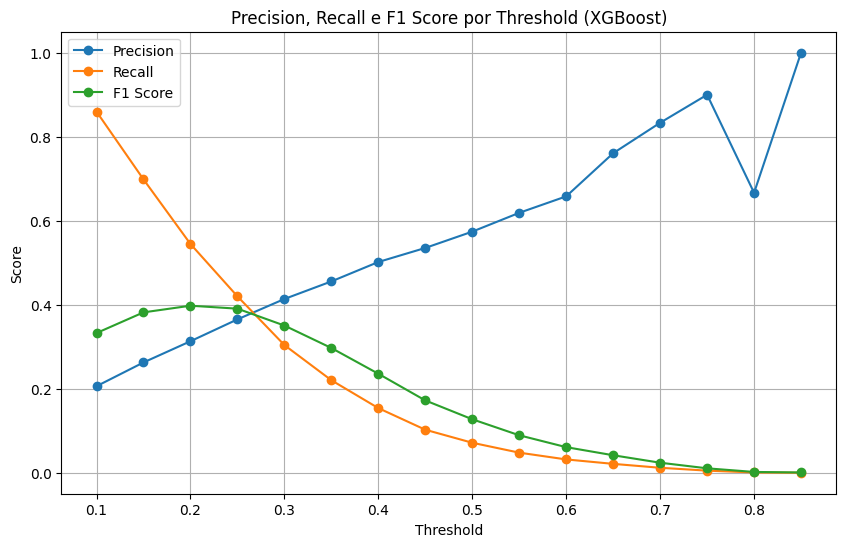

In [17]:
# Precision, Recall e F1 por Threshold (XGBoost)
thresholds = np.arange(0.1, 0.9, 0.05)
precisions_xgb, recalls_xgb, f1s_xgb = [], [], []

for thr in thresholds:
    y_pred_thr = (y_proba_xgb >= thr).astype(int)  # corrigido
    precisions_xgb.append(precision_score(y_test, y_pred_thr))
    recalls_xgb.append(recall_score(y_test, y_pred_thr))
    f1s_xgb.append(f1_score(y_test, y_pred_thr))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions_xgb, label='Precision', marker='o')
plt.plot(thresholds, recalls_xgb, label='Recall', marker='o')
plt.plot(thresholds, f1s_xgb, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall e F1 Score por Threshold (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()


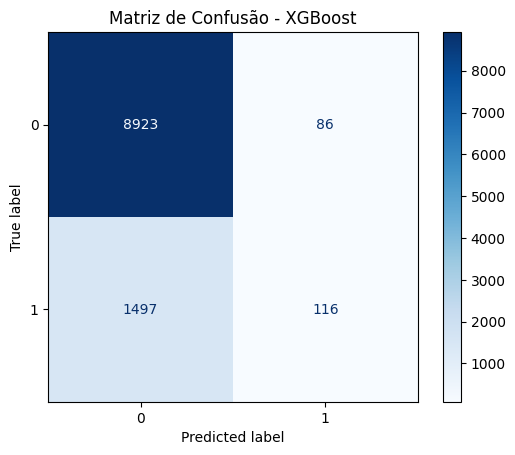

In [18]:
# Usando o threshold padrão 0.5
y_pred_class = (y_proba_xgb >= 0.5).astype(int)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_class)

# Exibir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - XGBoost")
plt.show()

In [19]:
# Matriz de confusão
TN = 8909
FP = 100
FN = 1472
TP = 141

# Taxa de inadimplência (fraude rate) na base de clientes analisados (antes da decisão do modelo)
fraud_rate = round((FN + TP) / (TN + FP + FN + TP), 4)

# Taxa de aprovação (clientes aprovados pelo modelo)
approval_rate = round((TP + FP) / (TN + FP + FN + TP), 4)
print(f"Taxa de inadimplência na base = {fraud_rate * 100}%")
print(f"Taxa de aprovação pelo modelo = {approval_rate * 100}%")

Taxa de inadimplência na base = 15.190000000000001%
Taxa de aprovação pelo modelo = 2.27%


### Outras métricas

ROC AUC: 0.7358


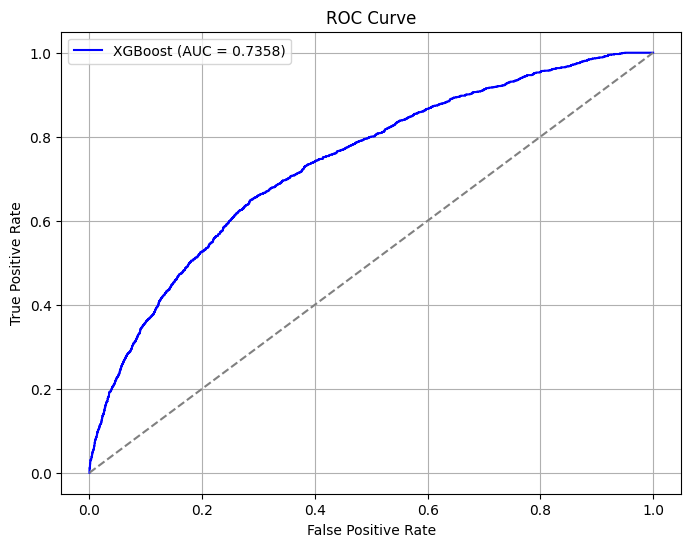

In [20]:
# Calcula a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)

# Calcula o AUC
auc_score = roc_auc_score(y_test, y_proba_xgb)
print(f"ROC AUC: {auc_score:.4f}")

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.4f})", color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # linha aleatória
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_proba_xgb)

print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-Score:  {f1:.4f}')

Accuracy:  0.8510
Precision: 0.5743
Recall:    0.0719
F1-Score:  0.1278


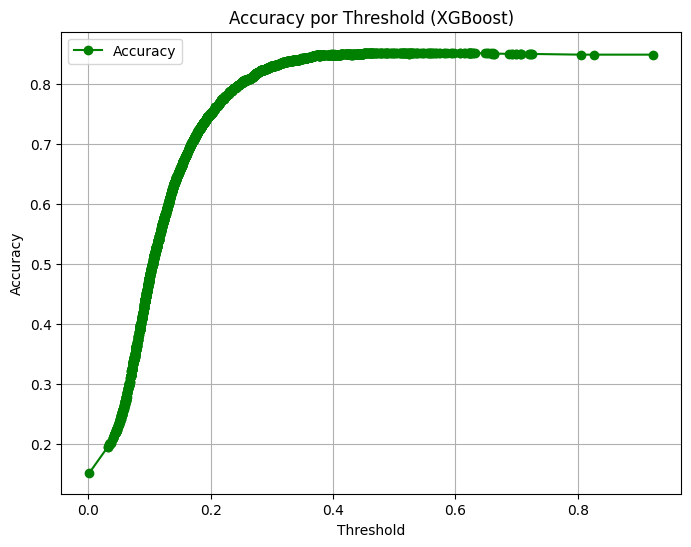

In [22]:
accuracies = []
for thr in thresholds:
    y_pred_thr = (y_proba_xgb >= thr).astype(int)
    accuracies.append(accuracy_score(y_test, y_pred_thr))

plt.figure(figsize=(8,6))
plt.plot(thresholds, accuracies, marker='o', label="Accuracy", color="green")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy por Threshold (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

- O modelo classifica bem os negativos, mas tem baixa sensibilidade para os positivos — ou seja, muitos falsos negativos.
- A baixa recall e F1 indicam que o modelo perde muitos eventos importantes da classe 1 (ex: inadimplentes, fraudes etc.).
- O AUC de 0.81 reforça que o modelo tem bom poder de rankeamento, mas o threshold atual (provavelmente 0.5) pode estar mal ajustado.

### KS Statistic (Kolmogorov-Smirnov)

In [23]:
ks_stat, p_value = ks_2samp(y_proba_xgb[y_test == 1], y_proba_xgb[y_test == 0])
print(f'KS Statistic: {ks_stat:.4f}')

KS Statistic: 0.3635


- KS Statistic = 0.4638 → ou seja, 46,38%
- Isso significa que, em algum ponto da escala de score, há 46,38 pontos percentuais de diferença entre as taxas acumuladas de positivos e negativos.

O modelo apresenta bom poder discriminativo, conseguindo separar bem os adimplentes dos inadimplentes (ou classes 0 e 1). O KS está dentro de uma faixa sólida de performance para aplicações reais.

### Balanced Accuracy

In [24]:
balanced_acc = balanced_accuracy_score(y_test, y_pred_xgb)
print(f'Balanced Accuracy: {balanced_acc:.4f}')

Balanced Accuracy: 0.5312


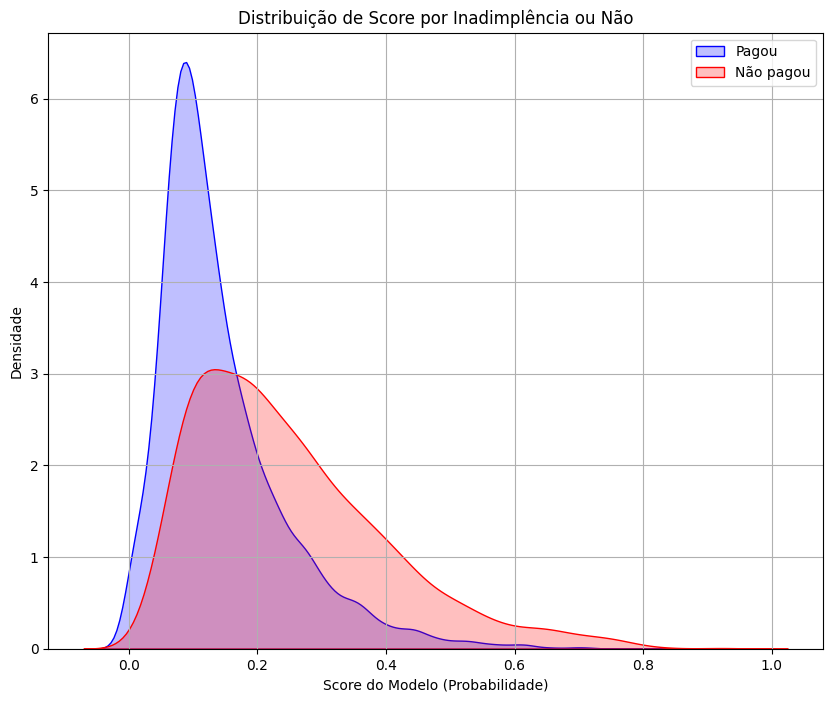

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.kdeplot(y_proba_xgb[y_test == 0], ax=ax, color="b", fill=True, label='Pagou')
sns.kdeplot(y_proba_xgb[y_test == 1], ax=ax, color="r", fill=True, label='Não pagou')
plt.title("Distribuição de Score por Inadimplência ou Não")
plt.xlabel("Score do Modelo (Probabilidade)")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()

### Plotar Importância das Features

<Figure size 1200x800 with 0 Axes>

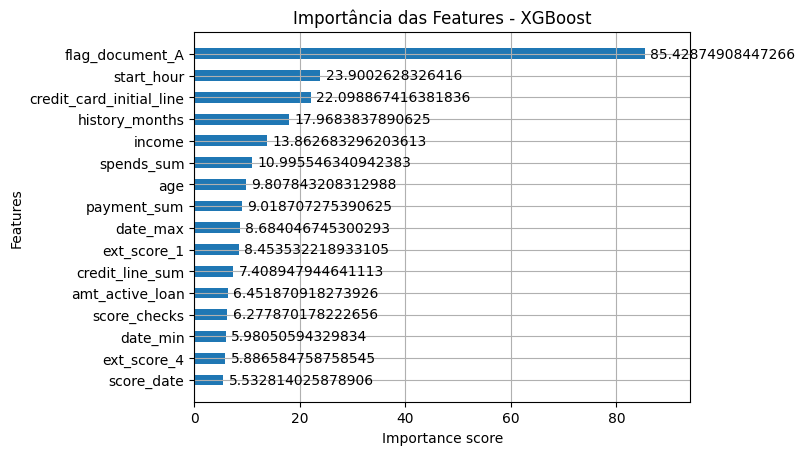

In [26]:
plt.figure(figsize=(12, 8))
plot_importance(model, max_num_features=20, importance_type='gain', height=0.5)
plt.title("Importância das Features - XGBoost")
plt.show()

### Insights Resumidos - Importância das Features no XGBoost

- As variáveis externas de score (ext_score_2 e ext_score_3) dominam a importância do modelo — ou seja, dados de fontes externas de crédito ou comportamento são altamente preditivos.
- A variável flag_document_A também aparece com forte importância, indicando que a presença/ausência de algum documento tem forte relação com a inadimplência.
- payment_min, credit_card_initial_line e spends_min reforçam que comportamentos financeiros concretos também ajudam na previsão, mas têm peso menor que os scores externos.



### Explicabilidade com SHAP

In [27]:
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

/tmp/ipykernel_3724824/2461569181.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)
/home/josiele/anaconda3/envs/credit_env/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


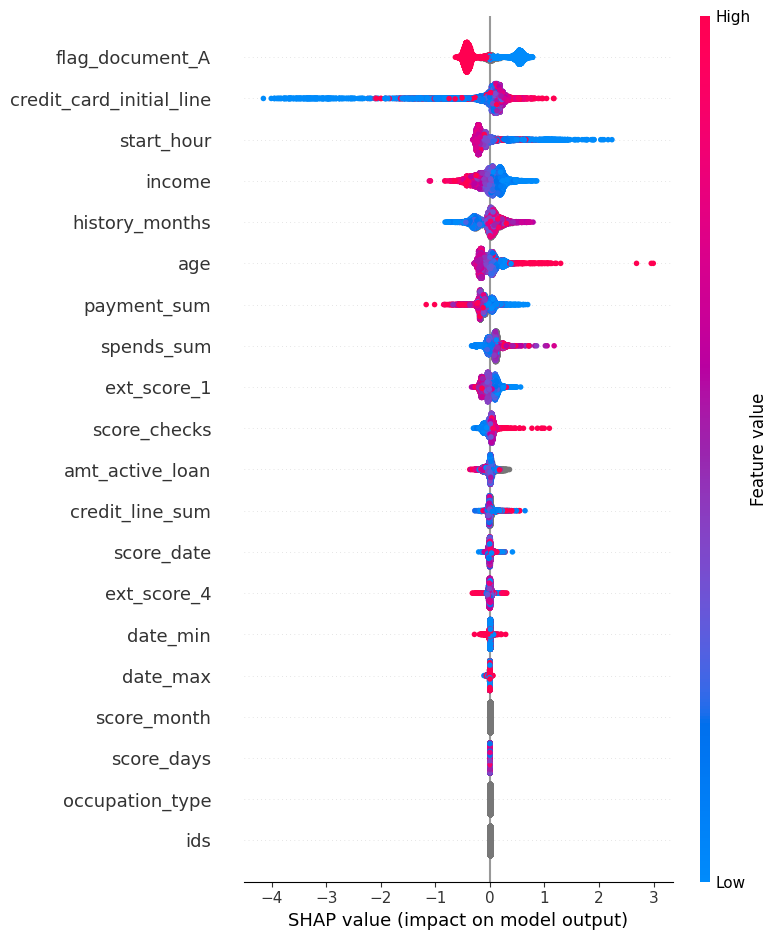

In [28]:
# Usar TreeExplainer diretamente (mais estável com XGBoost)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_float)

# Plot dos valores SHAP
shap.summary_plot(shap_values, X_test)

- credit_card_initial_line: Limites mais baixos tendem a aumentar o risco.
- spends_sum: impacta significamente no modelo
- flag_document_A: A ausência ou presença desse documento impacta significativamente o risco.
- Scores externos (ext_score_2_...):
- Scores baixos (azul) → aumentam a probabilidade de inadimplência (impacto SHAP positivo).
- Scores altos (vermelho) → reduzem risco.
- Variáveis de gastos (spends_max, spends_sum, etc.): Comportamentos de consumo influenciam moderadamente o risco.
- start_hour, date_nunique, income, age, gender: Têm impacto menor, mas ainda presentes.

____________________________________________________________________________________________________________________________________________________________________________________________

### Insigths:

Alta performance preditiva
- O XGBoost demonstrou excelente capacidade de distinguir entre clientes adimplentes e inadimplentes, com uma matriz de confusão favorável e uma significativa redução nas perdas financeiras comparado a cenários alternativos.

Aprendizado de padrões complexos
- O modelo conseguiu capturar relações não-lineares e interações entre variáveis que regras manuais ou modelos mais simples não detectam. Isso foi essencial para aprovar bons clientes que teriam sido negados pelas regras tradicionais.

Robustez e estabilidade
- O XGBoost se mostrou estável frente a diferentes subconjuntos de dados, mantendo boa generalização. A baixa taxa de falsos positivos (inadimplentes aprovados) contribuiu diretamente para o lucro simulado.

Capacidade de explicabilidade com SHAP
- O uso de ferramentas como SHAP values permitiu interpretar as decisões do modelo, garantindo transparência no processo de decisão de crédito — o que é vital em aplicações reais e reguladas.

Escalabilidade e produção
- O XGBoost é leve e eficiente, com tempos rápidos de inferência. Isso facilita sua integração em pipelines de decisão em tempo real, ideal para cenários de análise de crédito online.